<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/sam_preprocessing/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U allennlp
!pip install -U pandas

Requirement already up-to-date: allennlp in /usr/local/lib/python3.6/dist-packages (0.8.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.1)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np
import pandas as pd

import torchvision.transforms as T

from allennlp.modules.elmo import Elmo, batch_to_ids


In [3]:
#Use pretrained ELMO weights. 
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 2, dropout=0)

02/19/2019 12:38:48 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [4]:
#Elmo test
sentences = [['First', 'sentence', '.'], ['Another', '.'], 
             ["Oh", "here", "we", "Go", "now", "you", "fool", "."], 
             ["meaninglesswordnotinvocab"]]
             
character_ids = batch_to_ids(sentences)

# The shape would be (#sentences, length_of_longest_sentence, len of longest word(in original corpus?)=50)
# Note if a word has n characters the first n+2 entries in its size 50 embedding would be used to
# represent it. '+2' because it seems like they implicitly add a start and end of word
# 'character'
print(character_ids.shape)

embeddings = elmo(character_ids)
print(embeddings.keys())
embed = embeddings["elmo_representations"]

# The length of embed is given by the num_output_representations we specfied
# when creating the ELMO class, I believe this are just the number of different
# weighted combination of the 3 layers in the "ELMO network" so could theortically
# be any integer but is usually 1 or 2
print(len(embed))
print(embed[0].shape)
print(embed[1].shape)


torch.Size([4, 8, 50])
dict_keys(['elmo_representations', 'mask'])
2
torch.Size([4, 8, 1024])
torch.Size([4, 8, 1024])


In [0]:
# ELMO takes a list of parsed sentences as an input
# It generates an embedding of length 1024 per word
# We then need to find a good method of combining the word vecs to create 
# a sentence embedding (this article is good: https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a). 


In [5]:
from google.colab import files

#File upload instructions:
  #1. Run this cell
  #2. Press "Choose Files" at the bottom of this cell
  #3. Select offenseval-training-v1.tsv locally to load it as the variable noisy_values  
  
file1 = files.upload()


In [65]:
train = pd.read_csv("offenseval-training-v1.tsv", delimiter="\t")
print(train.shape)
print(train.head())

(13240, 5)
      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  


In [66]:
train.count()

id           13240
tweet        13240
subtask_a    13240
subtask_b     4400
subtask_c     3876
dtype: int64

In [67]:
total = train['id'].count().item()
off_count = train[train['subtask_a'] == "OFF"]['id'].count()

print("Number of offensive", off_count)
print("Number of inoffensive", total - off_count)

Number of offensive 4400
Number of inoffensive 8840


**The above shows that the training dataset is not very balanced (in offensive is about twice as much). How could this be addressed. Get more data? Augment offensive comments by adding neutral words to create more data or concat offensive and inoffensive comments to make new offensive comments?**

In [79]:
training_percent = 0.8
training_size = int(training_percent * total)
validation_size = total - training_size

corpus = train['tweet'].to_numpy()
labels = train['subtask_a']
labels[labels == 'OFF'] = 1
labels[labels == 'NOT'] = 0
labels = labels.to_numpy(dtype=np.float).reshape(-1, 1)

indices = list(range(total))
np.random.shuffle(indices)
training_sents = corpus[indices[:training_size]]
training_labels = labels[indices[:training_size]]

validation_sents = corpus[indices[training_size:]]
validation_labels = labels[indices[training_size:]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
import re

def get_tokenised_corpus(corpus):
    """
    This assumes the corpus can be iterated through and
    retains the order in which the sentences appeared in the corpus
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in corpus:
        tokenized_sentence = []
        for token in re.split(r'\s', sentence.lower()): # simplest split is 
            if token:
              # To avoid the empty string
              tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)
    
    return tokenized_corpus

In [81]:
training_ids = batch_to_ids(get_tokenised_corpus(training_sents))
validation_ids = batch_to_ids(get_tokenised_corpus(validation_sents))

print(training_ids[:2])

tensor([[[259,  65, 118,  ..., 261, 261, 261],
         [259,  65, 118,  ..., 261, 261, 261],
         [259, 118, 111,  ..., 261, 261, 261],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[259, 120, 105,  ..., 261, 261, 261],
         [259, 117, 105,  ..., 261, 261, 261],
         [259, 101, 102,  ..., 261, 261, 261],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]])


In [0]:
class SimpleClassifier(nn.Module):
    def __init__(self, out_channels, window_size, dropout):
        super(SimpleClassifier, self).__init__()
        self.embeddings = Elmo(options_file, weight_file, 1, dropout=0)
        embedding_dim = 1024
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(out_channels, 1)
        
    def forward(self, x):
        # x is the output from batch_to_ids
        
        
        # Only looking at one (the first) layer from elmo for now 
        # which is my I am indexing at 0
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = self.embeddings(x.type(torch.long))['elmo_representations'][0].unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
 
        return self.fc( self.dropout(pooled))

In [0]:
 def accuracy(output, target):
    with torch.no_grad():
        prob_output = torch.sigmoid(output)

        prob_output[prob_output > 0.5] = 1.
        prob_output[prob_output <= 0.5] = 0.

        acc = (prob_output == target).sum(dtype=torch.float) / output.shape[0]
 
    return acc

def f_measure(output, gold):
  
  with torch.no_grad():
    prob_output = torch.sigmoid(output)

    prob_output[prob_output > 0.5] = 1.
    prob_output[prob_output <= 0.5] = 0.

    TP = FN = FP = TN = 0

    for i in range(gold.shape[0]):
      if gold[i] == prob_output[i]:
        if gold[i] == 1:
          TP += 1.
        else:
          TN += 1.
      else:
        if gold[i] == 1:
          FN += 1.
        else:
          FP += 1.
          
    print("TP, FN, FP, TN", TP, FN, FP, FP)

    recall = TP/(TP + FN) if FN else 0
    precision = TP/(TP + FP) if FP else 0
    fscore = 2 * precision * recall /(precision + recall) if precision and recall else 0
  
  print("Recall: %.2f, Precision: %.2f, F-measure: %.2f" % (recall, precision, fscore))

In [0]:
BATCH_SIZE = 32
data_loader = DataLoader(TensorDataset(training_ids, torch.from_numpy(training_labels)), batch_size=BATCH_SIZE, shuffle=True)

In [0]:
USE_GPU = True
dtype = torch.long

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [91]:
model = SimpleClassifier(out_channels=100, window_size=3, dropout=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

02/19/2019 15:20:37 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [0]:
validation_ids = torch.as_tensor(validation_ids).to(device, dtype=dtype)
validation_labels = torch.as_tensor(validation_labels).to(device, dtype=torch.float)

NUM_EPOCHS = 1
training_losses = []
training_accs = []
validation_losses = []
validation_accs = []

for epoch in range(NUM_EPOCHS):
  epoch_loss = 0
  epoch_acc = 0
  
  print("Epoch", epoch)
  
  for sent_ids, target in data_loader:
    model.train()
    optimizer.zero_grad()

    sent_ids = sent_ids.to(device, dtype=dtype)
    target = target.to(device, dtype=torch.float)

    logits = model(sent_ids).type(torch.cuda.FloatTensor)

    loss = loss_fn(logits, target)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.detach().item()
    epoch_acc += accuracy(logits, target)
  
  epoch_loss = epoch_loss/BATCH_SIZE
  epoch_acc = epoch_acc/BATCH_SIZE

  model.eval()
  with torch.no_grad():
    logits = model(validation_ids)
    logits = logits.type(torch.cuda.FloatTensor)

    validation_loss = loss_fn(logits, validation_labels).item()
    validation_acc = accuracy(logits, validation_labels).item()
    
    print(f'| Epoch: {epoch:02} | Train. Loss: {epoch_loss:.3f} | Train. Acc: {epoch_acc*100:.2f}| Val. Loss: {validation_loss:.3f} | Val. Acc: {validation_acc*100:.2f}% \n')
    f_measure(logits, validation_labels)
    
  training_losses.append(epoch_loss)
  training_accs.append(epoch_acc)
  validation_losses.append(validation_loss)
  validation_accs.append(validation_acc)

        
        
    

Epoch 0


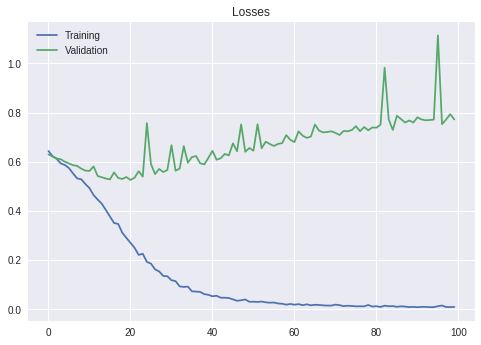

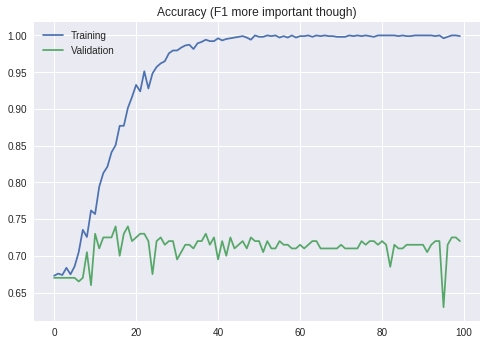

In [78]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(training_losses, label='Training')
ax1.plot(validation_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

fig2, ax2 = plt.subplots()

ax2.plot(training_accs, label='Training')
ax2.plot(validation_accs, label='Validation')

ax2.set_title("Accuracy (F1 more important though)")
ax2.legend()

plt.show()